In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics.pairwise import rbf_kernel

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from ipywidgets import interact, FloatSlider, Checkbox

In [2]:
X, y = make_moons(800, noise=0.17, random_state=42)
y[y==0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

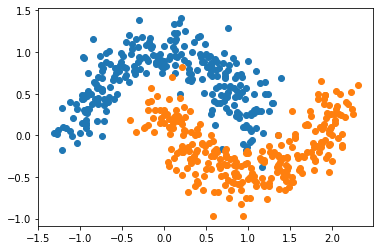

In [3]:
plt.scatter(X_train[y_train==-1, 0], X_train[y_train==-1, 1])
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1])
plt.show()

In [4]:
from sklearn.neighbors import DistanceMetric

metric = 'euclidean'
# metric = 'minkowski'  # 'euclidean'
dist = DistanceMetric.get_metric(metric)

clf = KNeighborsClassifier(n_neighbors=2, metric=metric)
clf.fit(X_train, y_train)
backup = np.copy(clf._y)

pred_y = clf.predict(X_test)

print(classification_report(y_test, pred_y, digits=3))

              precision    recall  f1-score   support

          -1      0.950     0.992     0.971       133
           1      0.992     0.947     0.969       131

    accuracy                          0.970       264
   macro avg      0.971     0.970     0.970       264
weighted avg      0.971     0.970     0.970       264



In [5]:
# gs = GridSearchCV(SVC(), {
#     'C': [0.5, 1, 10, 20, 50, 100],
#     'gamma': ['scale', 'auto', 0.1, 0.5, 0.8, 0.9]
# })
# gs.fit(X_train, y_train)
# clf = gs.best_estimator_
# backup = np.copy(clf._dual_coef_)
# print('Best estimator:', clf)

# res = pd.DataFrame(gs.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
# res[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']].head()

In [6]:
pred_y = clf.predict(X_test)
print(classification_report(y_test, pred_y, digits=3))

              precision    recall  f1-score   support

          -1      0.950     0.992     0.971       133
           1      0.992     0.947     0.969       131

    accuracy                          0.970       264
   macro avg      0.971     0.970     0.970       264
weighted avg      0.971     0.970     0.970       264



In [7]:
def get_kernel_matrix(x_probe, mpy=False):
    km = dist.pairwise(X_train, x_probe) #rbf_kernel(clf.support_vectors_, x_probe, gamma=gamma)
    # km = np.array([np.linalg.norm(X_train[i, :] - x_probe) for i in range(X_train.shape[0])])
    # if mpy:
    #     km *= y_train[clf.support_].reshape(-1, 1)
    return km

def find_tipping_point(x_probe, beyond_end=5):
    km = get_kernel_matrix(x_probe, False)

    def ksvm_label_flip(inds):
        prev = clf.predict(x_probe)[0]
        # Create coefficient backup
        backup = np.copy(clf._y)
        # Flip labels
        clf._y[inds] = 1 - clf._y[inds]
        # Check prediction
        after = clf.predict(x_probe)[0]
        # Restore coefficients
        clf._y = backup
        return prev, after

    # Find the tipping point
    label_flip_len = -1
    # inds = np.flip(km.argsort(axis=0).flatten())
    inds = km.argsort(axis=0).flatten()
    for i in range(1, len(inds)+1):
        p, a = ksvm_label_flip(inds[:i])
        if p != a:
            label_flip_len = i
            # print("Label flips:", label_flip_len := i)
            inds = inds[:label_flip_len + beyond_end]
            break
    return km, inds, label_flip_len, inds


In [12]:
def make_meshgrid(x, y, h=.03):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    plt.contour(xx, yy, Z, [0])
    return out

@interact(
    x1=FloatSlider(min=-1.7, max=1.7, step=0.01, value=0, continuous_update=False),
    x2=FloatSlider(min=-1.7, max=1.7, step=0.01, value=0, continuous_update=False),#, orientation='vertical'),
    no_backup=Checkbox(value=True, description='Flip labels'))
def calculate(x1=0, x2=0, no_backup=True):
    x_probe = np.array([[x1, x2]])
    km, inds, label_flip_len, sv_inds = find_tipping_point(x_probe, 0)
    # label_flip_len = 0
    if no_backup:
        clf._y[sv_inds] = 1 - clf._y[sv_inds]
    print(f'# of flips: {label_flip_len}; indices: {sv_inds}')
    res = clf.predict(x_probe)[0]
    print(f'Predict: {res}')
    
    plt.figure(figsize=(8, 6))

    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.2)
    # if no_backup:
    #     clf._dual_coef_ = np.copy(backup)
    if no_backup:
        clf._y[sv_inds] = 1 - clf._y[sv_inds]
    plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], label='-1', alpha=0.2)
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='+1', alpha=0.2)
    plt.scatter(X_train[inds, 0], X_train[inds, 1], label='flipped', color='red')
    plt.scatter(x_probe[:, 0], x_probe[:, 1], color='black', label='probe')
    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.legend()
    plt.show()


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1', max=1.7, min=-1.7, ste…